In [1]:
from scipy.special import gammaln
import matplotlib
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
import healpy as hp
from astropy.io import fits
from astropy import conf
from astropy.table import Table, vstack, hstack, join
from astropy.coordinates import Distance
from astropy.cosmology import Planck18, LambdaCDM
import numpy as np
import fitsio
import numpy.lib.recfunctions as rfn
import os
import pickle
import vast.catalog.void_catalog as void_catalog




In [2]:
#Load data

galaxy_table = Table.read(
    '/global/homes/j/jkneiss/galaxy_table_DR2_voids.fits',
    format='fits'
)

In [3]:
def get_bayes_factor(data_1, data_2, c = 1, max_depth=6, aj=lambda depth: depth**2, log_BF=False):
    """
    nonparamteric Bayes factors

    parameters:

    data_1 : arraylike
        Numpy array of data points sampled from the first distribution
    data_2 : arraylike
        Numpy array of data points sampled from the second distribution
    c : int 
        The tunable paramter c descibed in https://arxiv.org/abs/0910.5060v3
    max_depth : int
        The maximum depth of the partially specified Polya tree as described in https://arxiv.org/abs/0910.5060v3
        The Polya tree has a tree height of max_depth.
    aj : function
        The prescription for calculateing aj terms as a function of tree depth 
        as described in https://arxiv.org/abs/0910.5060v3
    log_BF: bool
        When False, the Bayes factor is returned, and when True, log10(Bayes factor) is returned
    """

    data_switch = len(data_1)
    combined_data = np.concatenate([data_1, data_2])
    del data_1, data_2

    # partition the data into quartiles
    quantiles = np.quantile(combined_data, np.linspace(0,1,2**max_depth + 1))

    # get the log bayes factor
    logbf = _get_bayes_factor(combined_data, data_switch, quantiles, low=0, high=1, c=c, depth=1, max_depth=max_depth, aj=aj)

    # return either the bayes factor or log bayes factor
    if log_BF:
        return logbf
    else:
        bf = np.exp(logbf)
        return bf

def _get_bayes_factor(combined_data, data_switch, quantiles, low, high, c, depth, max_depth,aj):
    """
    helper function called by get_bayes_factor

    parameters:

    combined_data : arraylike
        Numpy array of data points sampled from the first and second distributions. 
        Data from the second distribution should follow after data from the first
    data_switch : int
        The array index seperating the two sampled distributions in combined_data
    low : float
        The low quantile for the current Polya tree node
    high : float
        The high quantile for the current Polya tree node
    c : int 
        The tunable paramter c descibed in https://arxiv.org/abs/0910.5060v3
    depth : int
        The depth of the current node in the Polya tree
    max_depth : int
        The maximum depth of the partially specified Polya tree as described in https://arxiv.org/abs/0910.5060v3
    aj : function
        The prescription for calculateing aj terms as a function of tree depth 
        as described in https://arxiv.org/abs/0910.5060v3
    
    """
    
    if depth > max_depth: 
        return 0

    # seelct quartiles
    low_q = quantiles[int((2**max_depth ) * low)]
    mid_q = quantiles[int((2**max_depth ) * (low+high)/2)]
    high_q = quantiles[int((2**max_depth ) * high)]

    # count data in quartiles
    if high == 1:
        data_1_low = np.count_nonzero((combined_data[:data_switch]>=low_q)*(combined_data[:data_switch]<=mid_q))
        data_2_low = np.count_nonzero((combined_data[data_switch:]>=low_q)*(combined_data[data_switch:]<=mid_q))
        data_1_high = np.count_nonzero((combined_data[:data_switch]>=mid_q)*(combined_data[:data_switch]<=high_q))
        data_2_high = np.count_nonzero((combined_data[data_switch:]>=mid_q)*(combined_data[data_switch:]<=high_q))
    else:
        data_1_low = np.count_nonzero((combined_data[:data_switch]>=low_q)*(combined_data[:data_switch]<mid_q))
        data_2_low = np.count_nonzero((combined_data[data_switch:]>=low_q)*(combined_data[data_switch:]<mid_q))
        data_1_high = np.count_nonzero((combined_data[:data_switch]>=mid_q)*(combined_data[:data_switch]<high_q))
        data_2_high = np.count_nonzero((combined_data[data_switch:]>=mid_q)*(combined_data[data_switch:]<high_q))

    # calculate the n_j terms for the current binnings
    data_1_n_j = [data_1_low, data_1_high]
    data_2_n_j = [data_2_low, data_2_high]

    # truncate the tree where there is no data
    if np.sum(data_1_n_j) == 0 or np.sum(data_2_n_j) == 0:
        return 0

    # calculate the a_j term for the current tree depth
    a_j = c * aj(depth)

    # calculate b_j

    log_gamma_summand_1 = 2 * gammaln(a_j) - gammaln(2 * a_j)
    log_gamma_summand_2 = gammaln(a_j + data_1_n_j[0] + data_2_n_j[0]) + gammaln(a_j + data_1_n_j[1] + data_2_n_j[1]) 
    log_gamma_summand_3 = - gammaln(2*a_j + data_1_n_j[0] + data_2_n_j[0] + data_1_n_j[1] + data_2_n_j[1])
    log_gamma_summand_4 = gammaln(2*a_j + data_1_n_j[0] + data_1_n_j[1]) + gammaln(2*a_j + data_2_n_j[0] + data_2_n_j[1])
    log_gamma_summand_5 = - gammaln(a_j + data_1_n_j[0]) - gammaln(a_j + data_2_n_j[0]) - gammaln(a_j + data_1_n_j[1]) - gammaln(a_j + data_2_n_j[1])

    log_b_j = log_gamma_summand_1 + log_gamma_summand_2 + log_gamma_summand_3 + log_gamma_summand_4 + log_gamma_summand_5

    # calculate the product of b_j terms on the left partition of the tree
    log_left_tree_b_j = _get_bayes_factor(combined_data, data_switch, quantiles, low, (low+high)/2, c, depth+1, max_depth, aj)

    # calculate the product of b_j terms on the right partition of the tree
    log_right_tree_b_j = _get_bayes_factor(combined_data, data_switch, quantiles, (low+high)/2, high, c, depth+1, max_depth, aj)

    # calculate the product of the b_j terms
    summed_b_j = log_b_j + log_left_tree_b_j + log_right_tree_b_j

    return summed_b_j


In [4]:
galaxy_table['ra'].name = 'RA'
galaxy_table['dec'].name = 'DEC'
galaxy_table['redshift'].name = 'Z'

In [5]:

def get_property(prop_name, algorithm, environment, sample):
    """ 
    select galaxy property

    prop_name: name of property

    algorithm: name of void-finding algorithm

    environment: name of galaxy environment for selection (void, wall, or all)

    sample: DESI tracer used for selection

    """
    if environment == 'void':
        gals = galaxy_table[galaxy_table[f'{algorithm}_FLAG'] == 1]
    elif environment == 'wall':
        gals = galaxy_table[galaxy_table[f'{algorithm}_FLAG'] == 0]
    elif environment == 'all':
        gals = galaxy_table[(galaxy_table[f'{algorithm}_FLAG'] == 0) + (galaxy_table[f'{algorithm}_FLAG'] == 1)]
    else:
        raise ValueError('Invalid environment:', environment)

    if sample == 'BGS':
        gals = gals[(gals['BGS_TARGET'] & 2**1 != 0) + (gals['BGS_TARGET'] & 2**0 != 0)]
    elif sample == 'BGS Bright':
        gals = gals[(gals['BGS_TARGET'] & 2**1 != 0)]
    elif sample != "DR2":
        raise ValueError('Invalid sample:', sample)
        
    if prop_name.lower() in ['m_r', 'mr', 'rabsmag']:
        return gals['ABSMAG01_SDSS_R']
    elif prop_name.lower() in ['log_mstar', 'logmstar']:
        return gals['LOGMSTAR']
    elif prop_name.lower() in ['color_ur', 'ur', 'u-r']:
        return gals['ABSMAG01_SDSS_U'] - gals['ABSMAG01_SDSS_R']
    elif prop_name.lower() in ['color_gr', 'gr', 'g-r']:
        return gals['ABSMAG01_SDSS_G'] - gals['ABSMAG01_SDSS_R']
        
    elif prop_name.lower() in ['halpha', 'halpha_ew']:
        return gals['HALPHA_EW']
    elif prop_name.lower() in ['log_halpha', 'log_halpha_ew']:
        halpha = np.full(len(gals), -np.inf)
        halpha[gals['HALPHA_EW']>0] = np.log10(gals['HALPHA_EW'][gals['HALPHA_EW']>0])
        return halpha
    elif prop_name.lower() == 'sfr':
        return gals['SFR']
    elif prop_name.lower() in ['z', 'redshift']:
        return gals['Z']
    #elif prop_name.lower() == '':
    #    return gals['']
    else:
        raise ValueError('Invalid Property:'+prop_name)

In [6]:
def get_mr_z_bin(redshift, zmin, zmax, mr, mrmin, mrmax, galaxy_property, prop_name):

    select = (redshift < zmax) * (redshift > zmin) * (mr < mrmax) * (mr > mrmin)
    if prop_name == 'halpha':
        galaxy_property=galaxy_property[select]
        galaxy_property = galaxy_property[galaxy_property>0]
        prop = np.log10(galaxy_property)
        prop = prop[(prop>-3)*(prop<5)]
        return prop
    return galaxy_property[select]

In [7]:
def property_histograms_data(prop_name, num_mr_bins=7, num_z_bins=7, mr_min=-20, mr_max=-17):
    """
    For each (Mr, z) bin used in plot_bayes_factor_heatmap, 
    plot a histogram comparing the galaxy property distribution
    for void vs wall galaxies.
    """

    # Load data
    void_property = get_property(prop_name, 'VF', 'void', 'BGS Bright')
    wall_property = get_property(prop_name, 'VF', 'wall', 'BGS Bright')
    void_redshift = get_property('z', 'VF', 'void', 'BGS Bright')
    wall_redshift = get_property('z', 'VF', 'wall', 'BGS Bright')
    void_mr = get_property('mr', 'VF', 'void', 'BGS Bright')
    wall_mr = get_property('mr', 'VF', 'wall', 'BGS Bright')

    # Define M_r quantile bins
    mr_mask = (void_mr >= mr_min) & (void_mr <= mr_max)
    mr_bins = np.quantile(void_mr[mr_mask],
                          np.linspace(0, 1, num_mr_bins))
    results=[]
    for mr_i, (mrmin, mrmax) in enumerate(zip(mr_bins[:-1], mr_bins[1:])):

        # Determine redshift bins
        void_pre_bin = get_mr_z_bin(void_redshift, 0, np.inf, void_mr, mrmin, mrmax, void_redshift, 'redshift')
        wall_pre_bin = get_mr_z_bin(wall_redshift, 0, np.inf, wall_mr, mrmin, mrmax, wall_redshift, 'redshift')
        chosen_bin = void_pre_bin if len(wall_pre_bin) > len(void_pre_bin) else wall_pre_bin

        z_bins = np.quantile(chosen_bin, np.linspace(0, 1, num_z_bins))

        # Loop over z bins
        for z_i, (zmin, zmax) in enumerate(zip(z_bins[:-1], z_bins[1:])):

            # Select property values for the bin
            void_bin = get_mr_z_bin(void_redshift, zmin, zmax, void_mr, mrmin, mrmax, 
                                    void_property, prop_name)
            wall_bin = get_mr_z_bin(wall_redshift, zmin, zmax, wall_mr, mrmin, mrmax, 
                                    wall_property, prop_name)

            # Need data from both environments
            if len(void_bin) == 0 or len(wall_bin) == 0:
                continue

            # Same downsampling as heatmap
            min_len = min(len(void_bin), len(wall_bin))
            np.random.seed(0)
            void_bin = np.random.choice(void_bin, min_len, replace=False)
            wall_bin = np.random.choice(wall_bin, min_len, replace=False)

            results.append((mr_i, z_i, mrmin, mrmax, zmin, zmax, void_bin, wall_bin))

    return(results)

In [8]:
def plot_bayes_factor_heatmap(prop_name, num_mr_bins=7, num_z_bins=7, linewidth=.2, axsize=15, color='PiYG', sample='BGS Bright'):
    """
    Plot Bayes factor heatmap of Wall vs void
    of property for different mr and redshift bins
    """
    
    # Get galaxy properties
    void_property = get_property(prop_name, 'VF', 'void', sample)
    wall_property = get_property(prop_name, 'VF', 'wall', sample)
    void_redshift = get_property('z', 'VF', 'void', sample)
    wall_redshift = get_property('z', 'VF', 'wall', sample)
    void_mr = get_property('mr', 'VF', 'void', sample)
    wall_mr = get_property('mr', 'VF', 'wall', sample)

    # Initialize Bayes factor storage
    bayes_factors = {
        'factors': [],
        'void_counts': [],
        'wall_counts': [],
        'zmin': [],
        'zmax': [],
        'mrmin': [],
        'mrmax': []
    }

    # Define magnitude bins (M_r)
    mr_mask = (void_mr >= -20) & (void_mr <= -17)
    mr_bins = np.quantile(void_mr[mr_mask],
                          np.linspace(0, 1, num_mr_bins ))

    for mrmin, mrmax in zip(mr_bins[:-1], mr_bins[1:]):
        # Pre-select redshift range for quantiles
        void_pre_bin = get_mr_z_bin(void_redshift, 0, np.inf, void_mr, mrmin, mrmax, void_redshift, 'redshift')
        wall_pre_bin = get_mr_z_bin(wall_redshift, 0, np.inf, wall_mr, mrmin, mrmax, wall_redshift, 'redshift')
        chosen_bin = void_pre_bin if len(wall_pre_bin) > len(void_pre_bin) else wall_pre_bin

        z_bins = np.quantile(chosen_bin, np.linspace(0, 1, num_z_bins))

        for zmin, zmax in zip(z_bins[:-1], z_bins[1:]):
            void_bin = get_mr_z_bin(void_redshift, zmin, zmax, void_mr, mrmin, mrmax, void_property, prop_name)
            wall_bin = get_mr_z_bin(wall_redshift, zmin, zmax, wall_mr, mrmin, mrmax, wall_property, prop_name)

            if len(void_bin) > 0 and len(wall_bin) > 0:
                # Downsample to equal sizes
                min_len = min(len(void_bin), len(wall_bin))
                np.random.seed(0)
                void_bin = np.random.choice(void_bin, min_len, replace=False)
                wall_bin = np.random.choice(wall_bin, min_len, replace=False)

                bf = get_bayes_factor(wall_bin, void_bin, log_BF=True)

                bayes_factors['factors'].append(bf)
                bayes_factors['void_counts'].append(len(void_bin))
                bayes_factors['wall_counts'].append(len(wall_bin))
                bayes_factors['zmin'].append(zmin)
                bayes_factors['zmax'].append(zmax)
                bayes_factors['mrmin'].append(mrmin)
                bayes_factors['mrmax'].append(mrmax)

    # Set up heatmap
    fig, ax = plt.subplots()
    cmap = matplotlib.colormaps[color]
    minima = min(bayes_factors['factors'])
    maxima = max(bayes_factors['factors'])
    lim= max(abs(minima),abs(maxima))
    norm = matplotlib.colors.Normalize(vmin=-lim, vmax=lim, clip=True)
    mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

    rectangles = []
    counts = []


    for zmin, zmax, mrmin, mrmax, bf, void, wall in zip(
            bayes_factors['zmin'], bayes_factors['zmax'],
            bayes_factors['mrmin'], bayes_factors['mrmax'],
            bayes_factors['factors'],
            bayes_factors['void_counts'], bayes_factors['wall_counts']):
        rectangles.append(Rectangle((zmin, mrmin), zmax - zmin, mrmax - mrmin, facecolor=cmap(norm(bf)), linewidth=linewidth))
        counts.append(void + wall)

    collection = PatchCollection(rectangles, alpha=0.6, match_original=True)
    ax.add_collection(collection)

    ax.set_xlim(0, 0.25)
    ax.set_ylim(-20, -17)
    plt.gca().invert_yaxis()
    plt.xlabel('Redshift(z)', fontsize=axsize)
    plt.ylabel('$M_r$', fontsize=axsize)
    cbar = plt.colorbar(mapper, ax=ax)
    cbar.set_label('Bayes Factor', fontsize=axsize)
    plt.title(f'Void-Wall Galaxy {prop_name} comparison\nbins of {np.mean(counts):.3g} ± {np.std(counts):.3g} galaxies')
    plt.show()

In [12]:
def plot_heatmap_diagnostic(prop_name, num_mr_bins=6, num_z_bins=6, linewidth=.2, axsize=15, color='PiYG', sample='BGS Bright', ax=None, mr_min=-20, mr_max=-14):
    """
    Plot Bayes factor heatmap of Wall vs void
    of property for different mr and redshift bins
    """
    if ax is None:
        fig, ax = plt.subplots()
    # Get galaxy properties
    void_property = get_property(prop_name, 'VF', 'void', sample)
    wall_property = get_property(prop_name, 'VF', 'wall', sample)
    void_redshift = get_property('z', 'VF', 'void', sample)
    wall_redshift = get_property('z', 'VF', 'wall', sample)
    void_mr = get_property('mr', 'VF', 'void', sample)
    wall_mr = get_property('mr', 'VF', 'wall', sample)

    # Initialize Bayes factor storage
    bayes_factors = {
        'factors': [],
        'void_counts': [],
        'wall_counts': [],
        'zmin': [],
        'zmax': [],
        'mrmin': [],
        'mrmax': []
    }

    # Define magnitude bins (M_r)
    mr_mask = (void_mr >= mr_min) & (void_mr <= mr_max)
    mr_bins = np.quantile(void_mr[mr_mask],
                          np.linspace(0, 1, num_mr_bins ))

    for mrmin, mrmax in zip(mr_bins[:-1], mr_bins[1:]):
        # Pre-select redshift range for quantiles
        void_pre_bin = get_mr_z_bin(void_redshift, 0, np.inf, void_mr, mrmin, mrmax, void_redshift, 'redshift')
        wall_pre_bin = get_mr_z_bin(wall_redshift, 0, np.inf, wall_mr, mrmin, mrmax, wall_redshift, 'redshift')
        chosen_bin = void_pre_bin if len(wall_pre_bin) > len(void_pre_bin) else wall_pre_bin

        z_bins = np.quantile(chosen_bin, np.linspace(0, 1, num_z_bins))

        for zmin, zmax in zip(z_bins[:-1], z_bins[1:]):
            void_bin = get_mr_z_bin(void_redshift, zmin, zmax, void_mr, mrmin, mrmax, void_property, prop_name)
            wall_bin = get_mr_z_bin(wall_redshift, zmin, zmax, wall_mr, mrmin, mrmax, wall_property, prop_name)

            if len(void_bin) > 0 and len(wall_bin) > 0:
                # Downsample to equal sizes
                min_len = min(len(void_bin), len(wall_bin))
                np.random.seed(0)
                void_bin = np.random.choice(void_bin, min_len, replace=False)
                wall_bin = np.random.choice(wall_bin, min_len, replace=False)

                bf = get_bayes_factor(wall_bin, void_bin, log_BF=True)

                bayes_factors['factors'].append(bf)
                bayes_factors['void_counts'].append(len(void_bin))
                bayes_factors['wall_counts'].append(len(wall_bin))
                bayes_factors['zmin'].append(zmin)
                bayes_factors['zmax'].append(zmax)
                bayes_factors['mrmin'].append(mrmin)
                bayes_factors['mrmax'].append(mrmax)

    # Set up heatmap
    cmap = matplotlib.colormaps[color]
    minima = min(bayes_factors['factors'])
    maxima = max(bayes_factors['factors'])
    lim= max(abs(minima),abs(maxima))
    norm = matplotlib.colors.Normalize(vmin=-lim, vmax=lim, clip=True)
    mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

    rectangles = []
    counts = []


    for zmin, zmax, mrmin, mrmax, bf, void, wall in zip(
            bayes_factors['zmin'], bayes_factors['zmax'],
            bayes_factors['mrmin'], bayes_factors['mrmax'],
            bayes_factors['factors'],
            bayes_factors['void_counts'], bayes_factors['wall_counts']):
        rectangles.append(Rectangle((zmin, mrmin), zmax - zmin, mrmax - mrmin, facecolor=cmap(norm(bf)), linewidth=linewidth))
        counts.append(void + wall)

    collection = PatchCollection(rectangles, alpha=0.6, match_original=True)
    ax.add_collection(collection)

    ax.set_xlim(0, 0.25)
    ax.set_ylim(mr_min, mr_max)
    plt.gca().invert_yaxis()
    plt.xlabel('Redshift(z)', fontsize=axsize)
    plt.ylabel('$M_r$', fontsize=axsize)
    cbar = plt.colorbar(mapper, ax=ax)
    cbar.set_label('Bayes Factor', fontsize=axsize)
    plt.title(f'Void-Wall Galaxy {prop_name} comparison\nbins of {np.mean(counts):.3g} ± {np.std(counts):.3g} galaxies')


In [10]:
def plot_heatmap_and_hist(prop_name, num_mr_bins=6, num_z_bins=6, mr_min=-20, mr_max=-17):
    """ 
    Plot Bayes Factor Heatmap in grid with 
    diagnostic histograms across mr and z bins
    """
    
    hist_data = property_histograms_data(prop_name,num_mr_bins,num_z_bins, mr_min=mr_min, mr_max=mr_max)

    nrows = num_mr_bins - 1
    ncols = num_z_bins

    fig = plt.figure(figsize=(10+2*nrows, 2*nrows))
    gs = GridSpec(nrows, ncols + 5, figure=fig)


    ax_heatmap = fig.add_subplot(gs[:, :5])

    plot_heatmap_diagnostic(prop_name,
                            num_mr_bins=num_mr_bins,
                            num_z_bins=num_z_bins,
                            ax=ax_heatmap, mr_min=mr_min, mr_max=mr_max)


    for (mr_i, z_i, mrmin, mrmax, zmin, zmax,
         void_bin, wall_bin) in hist_data:

        ax = fig.add_subplot(gs[mr_i, z_i + 5])

        ax.hist(wall_bin, bins=40,
                histtype='step', color='black', alpha =.6)
        ax.hist(void_bin, bins=40,
                histtype='step', color='red', alpha=.6)
        """

        ax.set_title(
            f"{mrmin:.2f} < M_r < {mrmax:.2f}\n"
            f"{zmin:.3f} < z < {zmax:.3f}",
            fontsize=8
        )
        """

        if mr_i == nrows - 1:
            ax.set_xlabel(prop_name)

        if z_i == 0:
            ax.set_ylabel("Count")

        ax.tick_params(labelsize=7)

    plt.tight_layout()
    plt.show()

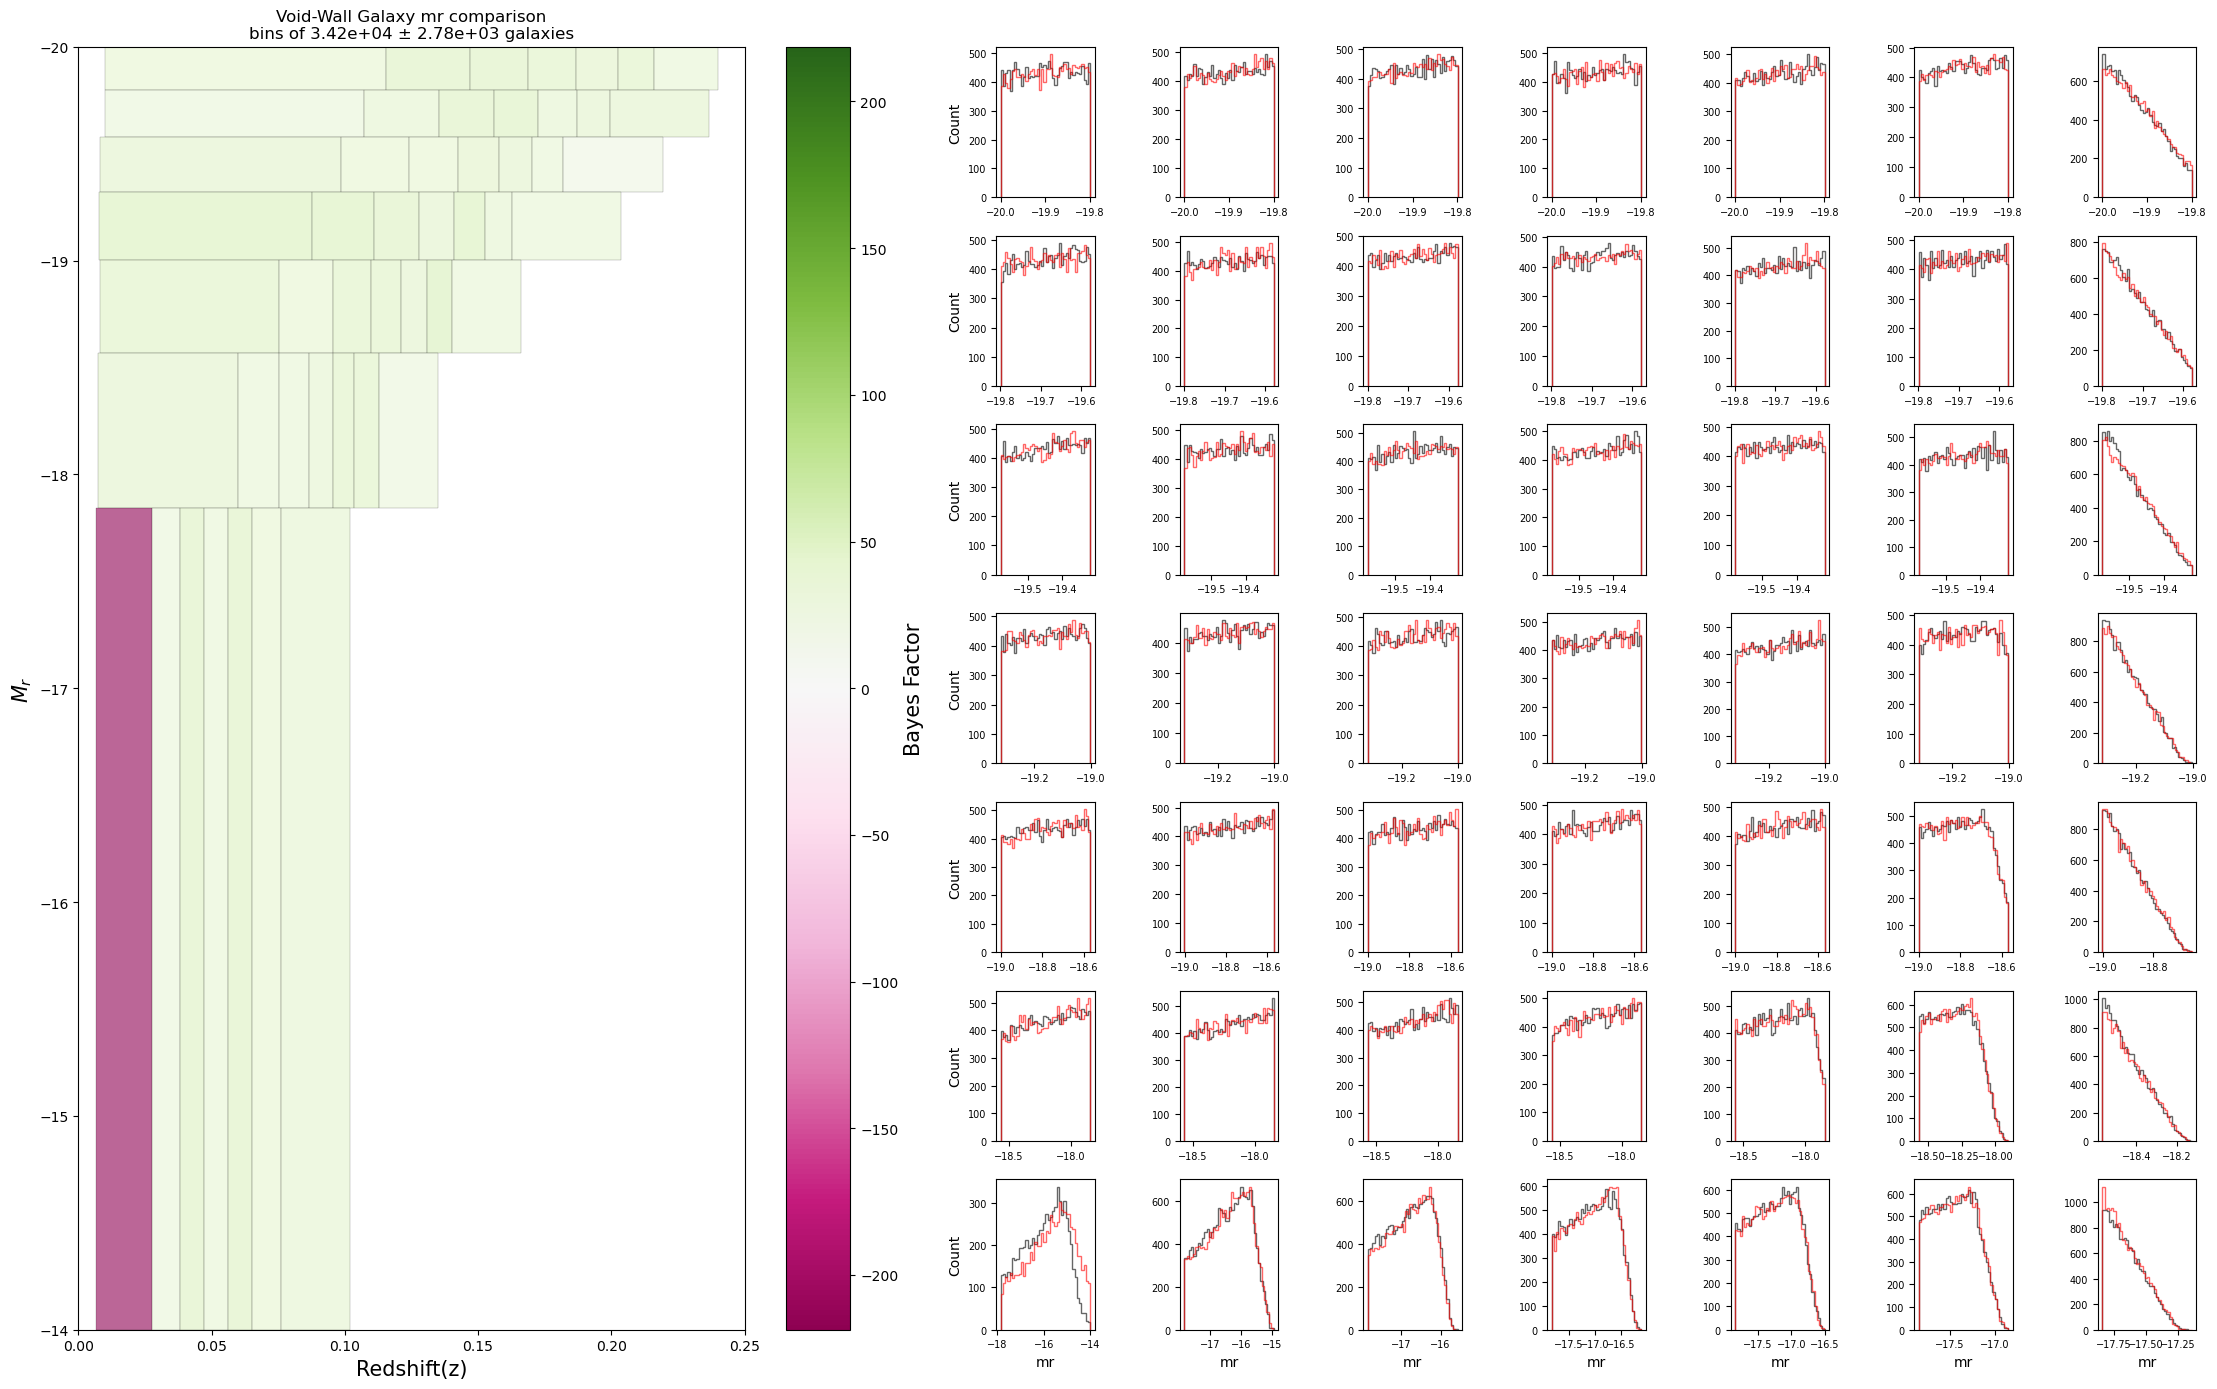

In [ ]:
for variable in ['mr','log_mstar','g-r','u-r','halpha']:
    plot_heatmap_and_hist(variable, num_mr_bins=8, num_z_bins=8, mr_min=-20, mr_max=-14)

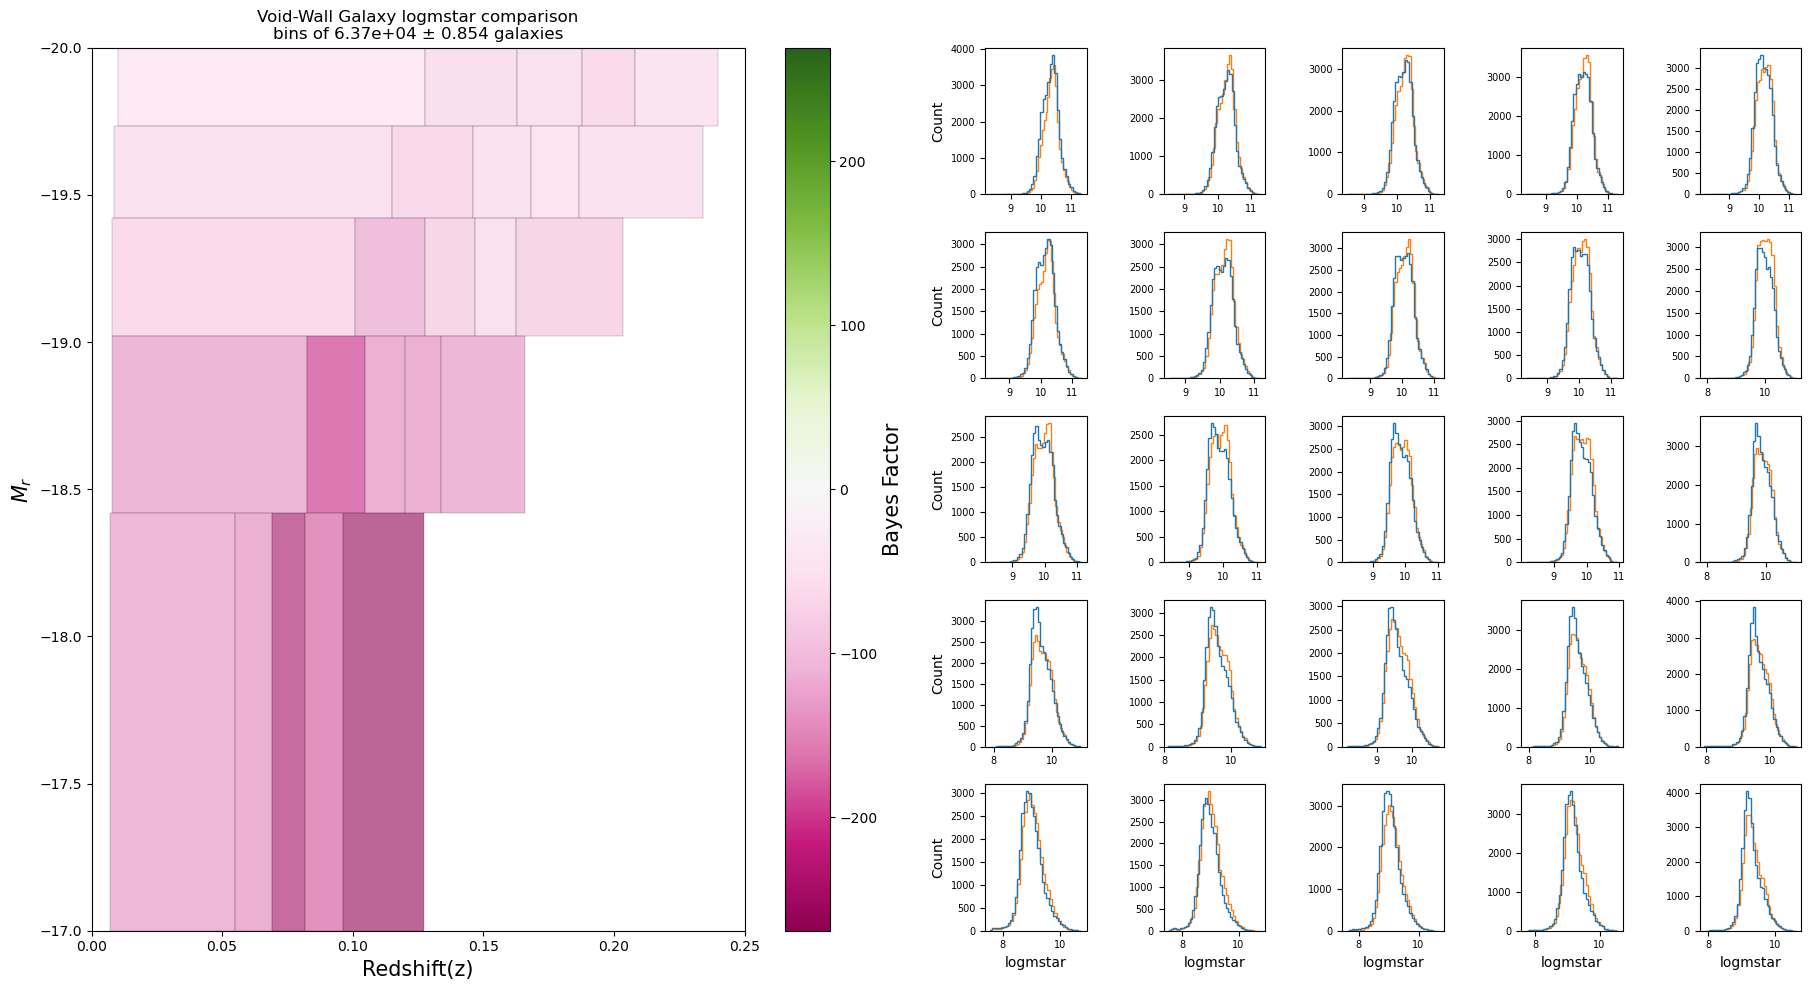

In [18]:
plot_heatmap_and_hist('logmstar', num_mr_bins=6, num_z_bins=6)

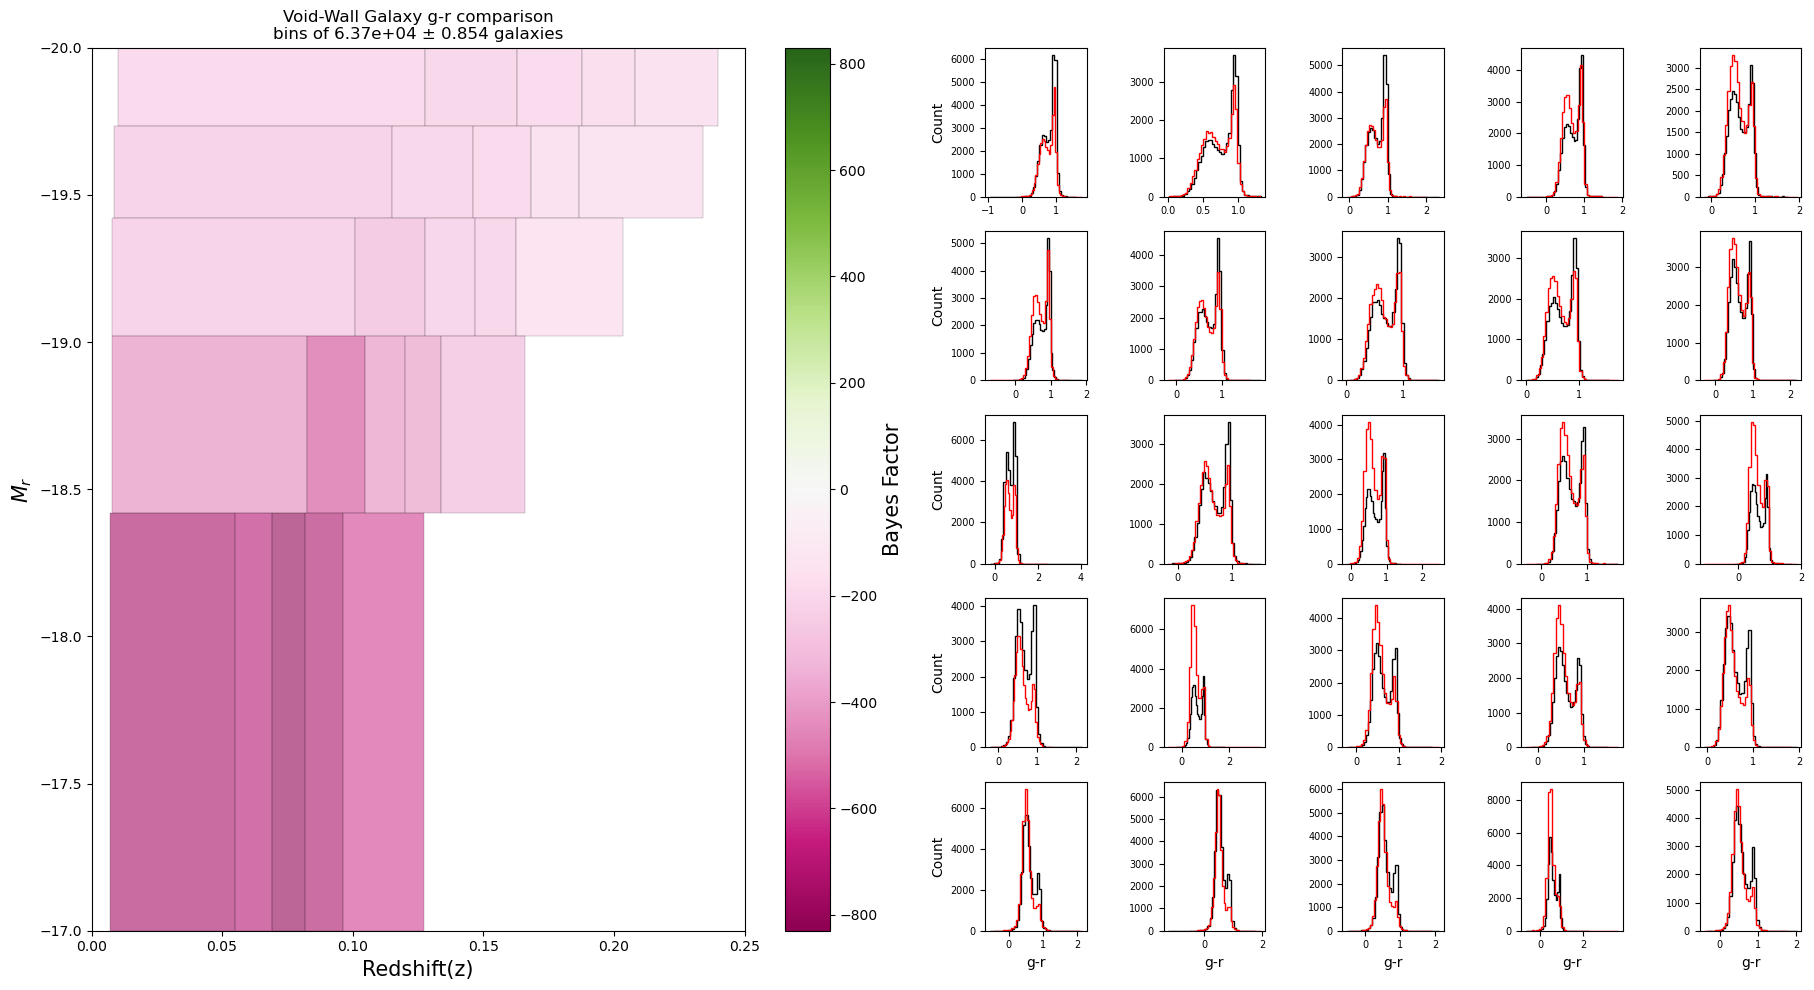

In [31]:
plot_heatmap_and_hist('g-r', num_mr_bins=6, num_z_bins=6)

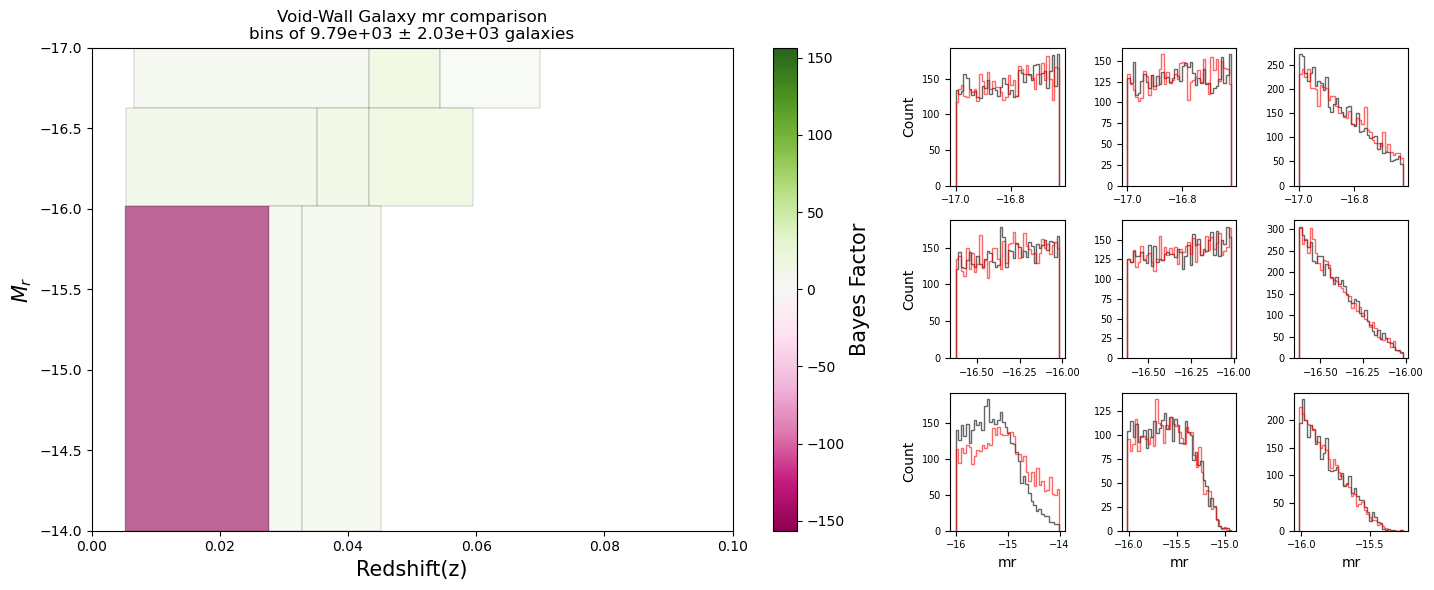

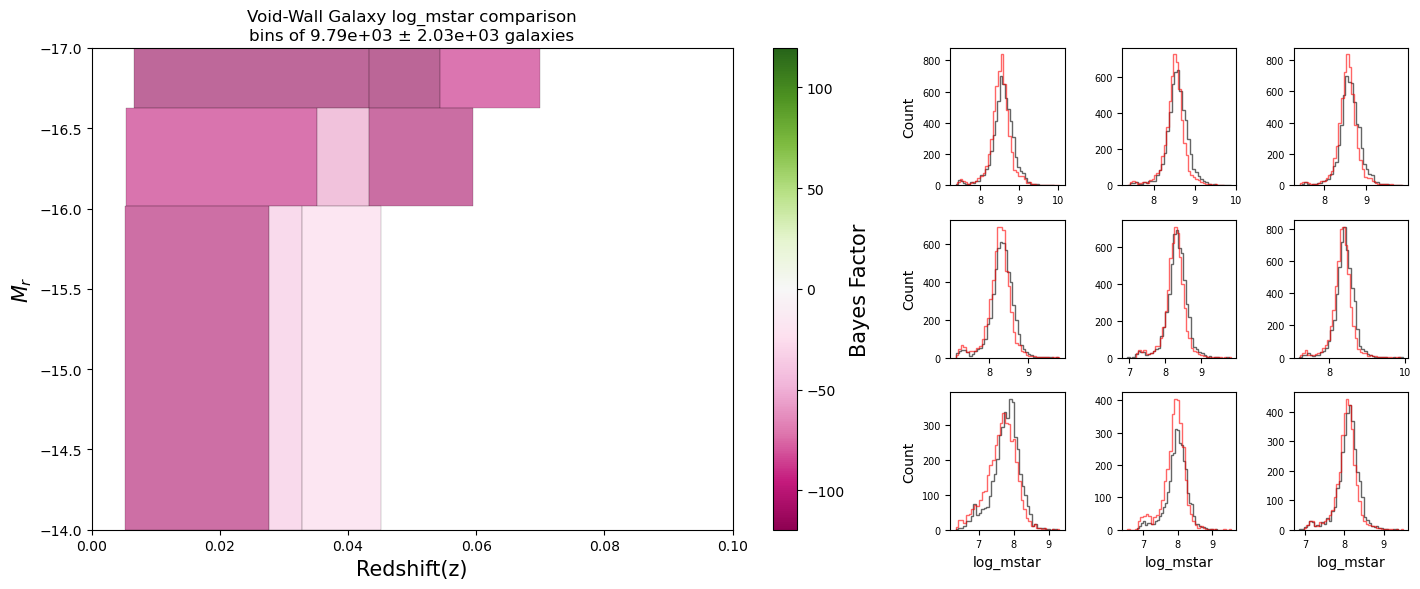

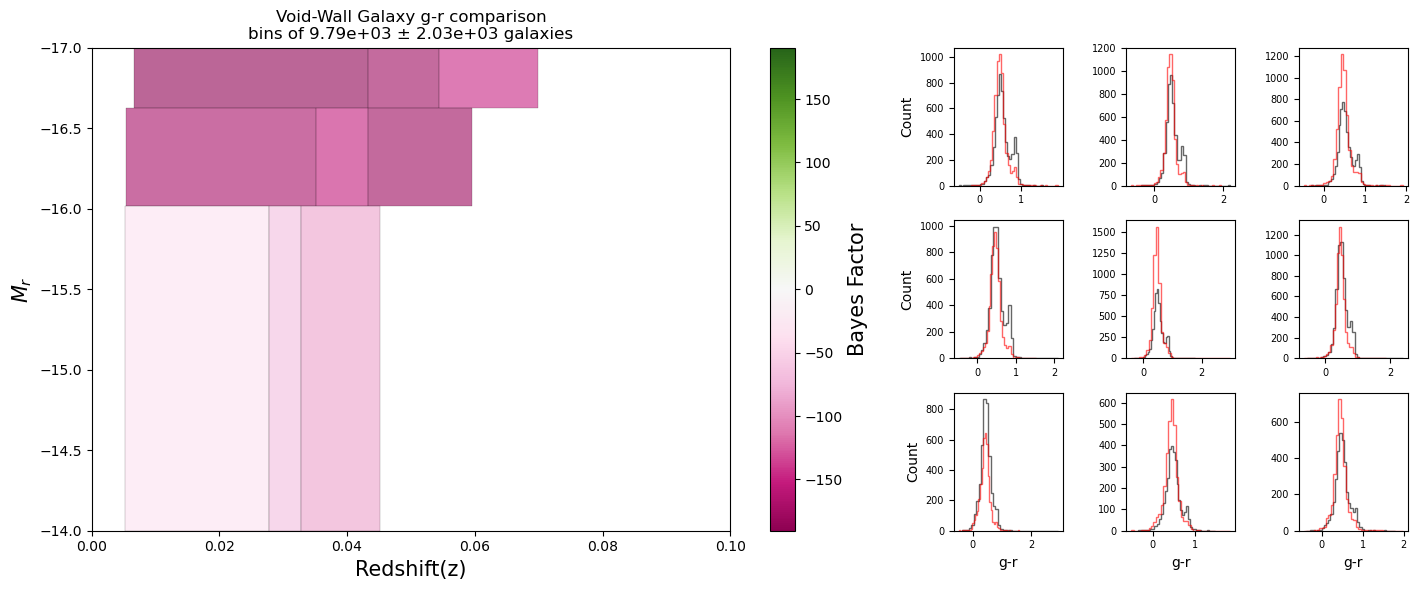

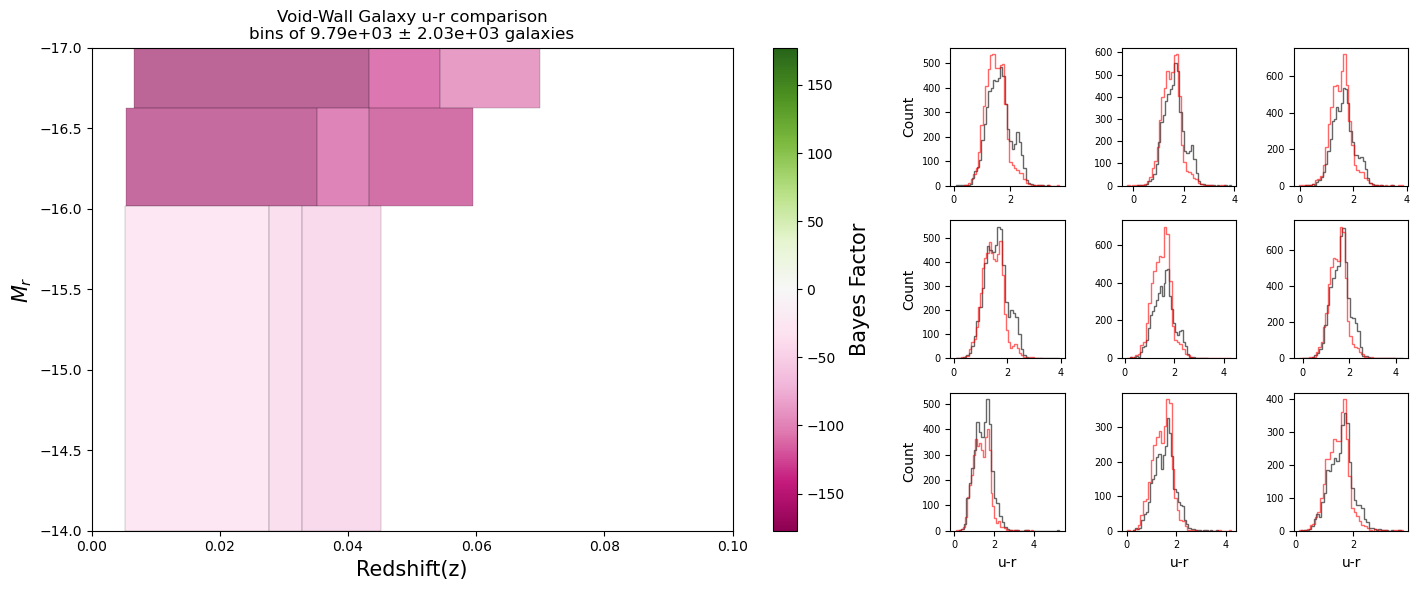

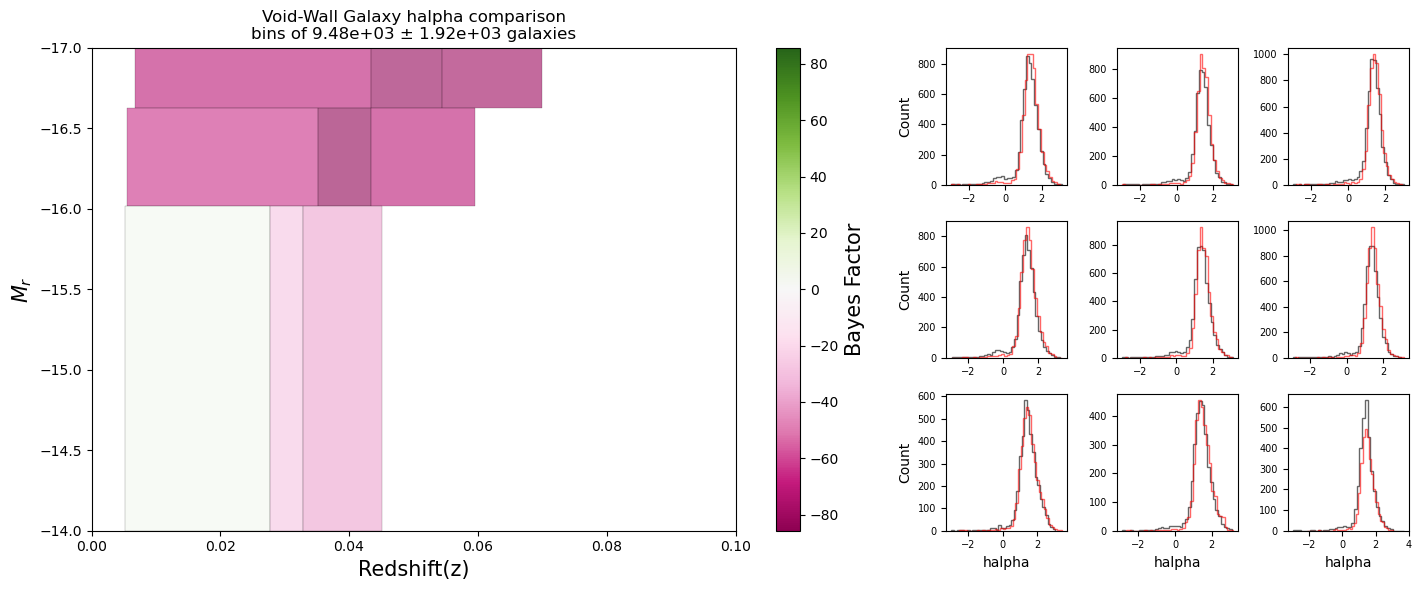

In [13]:
for variable in ['mr','log_mstar','g-r','u-r','halpha']:
    plot_heatmap_and_hist(variable, num_mr_bins=4, num_z_bins=4, mr_min=-17, mr_max=-14)

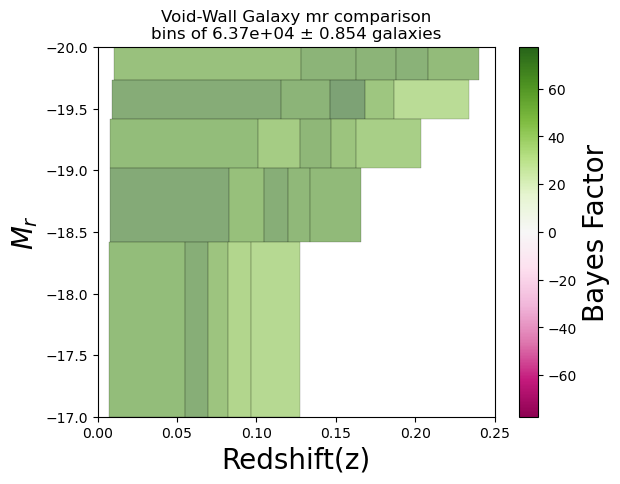

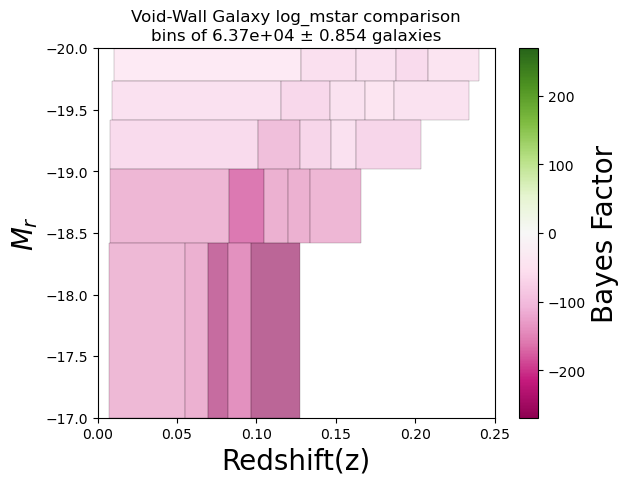

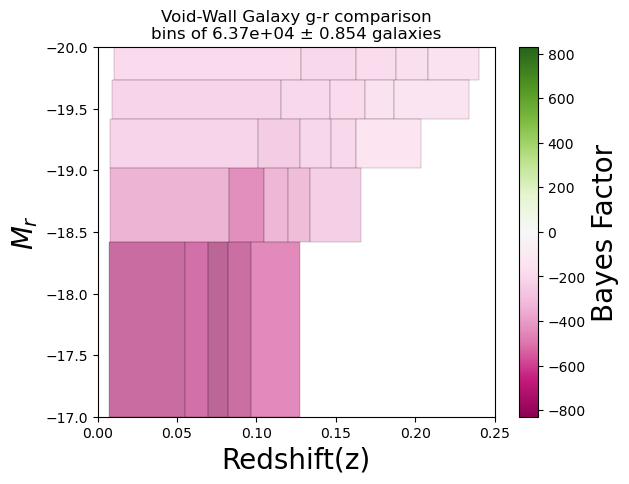

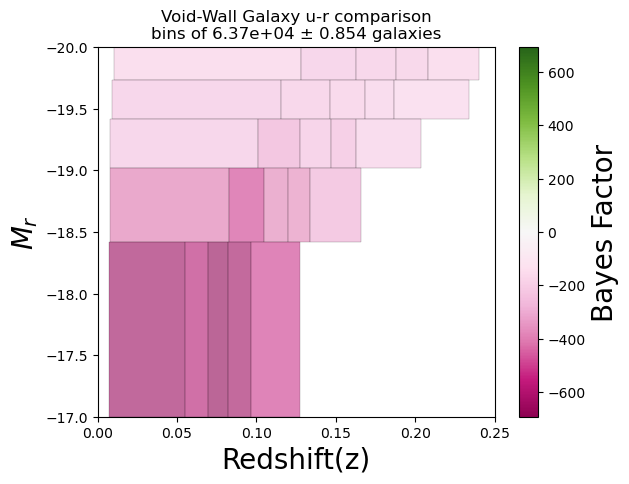

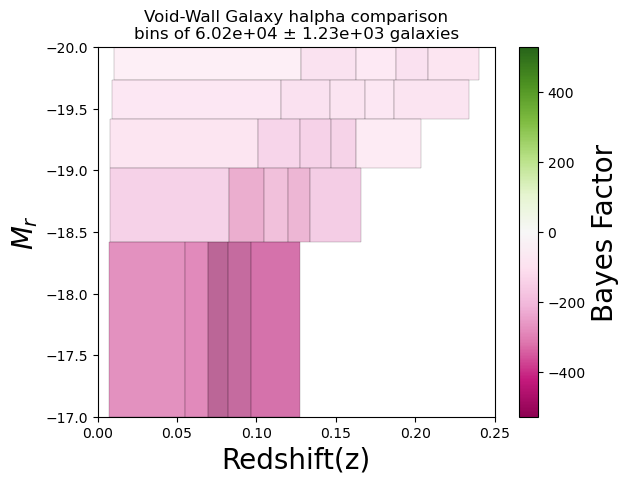

In [12]:
for variable in ['mr','log_mstar','g-r','u-r','halpha']:
    plot_bayes_factor_heatmap(variable, num_mr_bins=6, num_z_bins=6, linewidth=.2, axsize=20, color='PiYG')

In [12]:
def check_sample_binning (mr_min=-20, mr_max=-17, sample= 'BGS Bright', num_bins=8):
    
    rshift = get_property('z', 'VF', 'all', sample)
    mr = get_property('mr', 'VF', 'all', sample)
    void_property = get_property('mr', 'VF', 'void', sample)
    wall_property = get_property('mr', 'VF', 'wall', sample)
    void_redshift = get_property('z', 'VF', 'void', sample)
    wall_redshift = get_property('z', 'VF', 'wall', sample)
    void_mr = get_property('mr', 'VF', 'void', sample)
    wall_mr = get_property('mr', 'VF', 'wall', sample)
    
    counts=[] 
    counts_wall = []
    counts_void = []
    
    mr_mask = (void_mr >= mr_min) & (void_mr <= mr_max)
    mr_bins = np.quantile(void_mr[mr_mask],
                          np.linspace(0, 1, num_bins))
    
    for mrmin, mrmax in zip(mr_bins[:-1], mr_bins[1:]):
        # Pre-select redshift range for quantiles
        void_pre_bin = get_mr_z_bin(void_redshift, 0, np.inf, void_mr, mrmin, mrmax, void_redshift, 'redshift')
        wall_pre_bin = get_mr_z_bin(wall_redshift, 0, np.inf, wall_mr, mrmin, mrmax, wall_redshift, 'redshift')
        chosen_bin = void_pre_bin if len(wall_pre_bin) > len(void_pre_bin) else wall_pre_bin
    
        z_bins = np.quantile(chosen_bin, np.linspace(0, 1, num_bins))
    
        for zmin, zmax in zip(z_bins[:-1], z_bins[1:]):
            void_bin = get_mr_z_bin(void_redshift, zmin, zmax, void_mr, mrmin, mrmax, void_property, 'mr')
            wall_bin = get_mr_z_bin(wall_redshift, zmin, zmax, wall_mr, mrmin, mrmax, wall_property, 'mr')
    
            rect = Rectangle(
                (zmin, mrmin),               # lower-left corner
                zmax - zmin,               
                mrmax - mrmin,               
                linewidth=1,
                edgecolor='red',
                facecolor='none',
                alpha=0.8
            )
    
            plt.gca().add_patch(rect)
    
            if len(void_bin) > 0 and len(wall_bin) > 0:
                # Downsample to equal sizes
                min_len = min(len(void_bin), len(wall_bin))
                np.random.seed(0)
                counts_wall.append(len(wall_bin))
                counts_void.append(len(void_bin))
                void_bin = np.random.choice(void_bin, min_len, replace=False)
                wall_bin = np.random.choice(wall_bin, min_len, replace=False)
                counts.append(2*min_len)
    
    plt.scatter(rshift, mr, s=.000005, color='black', alpha =.6)
    plt.xlabel('Redshift')
    plt.xlim(0, .24)
    plt.ylabel(r'$M_r$')
    plt.ylim(mr_min,mr_max)
    plt.gca().invert_yaxis()
    
    print("Estimated Counts ="+str(np.mean(counts)))


Estimated Counts =46412.65306122449


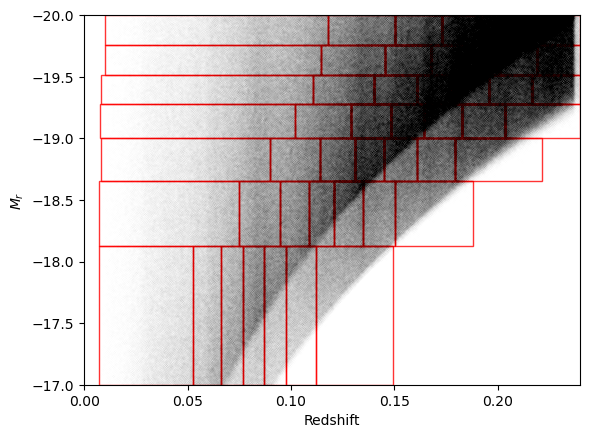

In [13]:
check_sample_binning(mr_min=-20, mr_max=-17, num_bins=8, sample='BGS')

In [75]:
print(counts_wall)

[19433, 22042, 21509, 24461, 25682, 23752, 25297, 18503, 21151, 20441, 22012, 24380, 25512, 21863, 18868, 19745, 20435, 20375, 21132, 24077, 22958, 18849, 17512, 21403, 19800, 19537, 20898, 21030, 19704, 16853, 17750, 20982, 19087, 19782, 18677, 17905, 19317, 15677, 16328, 16791, 19371, 20189, 14924, 14036, 16260, 20420, 20680, 15652, 15636]


In [76]:
print(counts_void)

[10213, 10213, 10214, 10213, 10214, 10213, 10213, 10213, 10213, 10214, 10213, 10214, 10213, 10213, 10213, 10213, 10213, 10214, 10213, 10213, 10213, 10213, 10213, 10213, 10214, 10213, 10213, 10213, 10213, 10213, 10214, 10213, 10214, 10213, 10213, 10213, 10213, 10214, 10213, 10214, 10213, 10213, 10213, 10213, 10214, 10213, 10214, 10213, 10213]


Estimated Counts =20087.081632653062


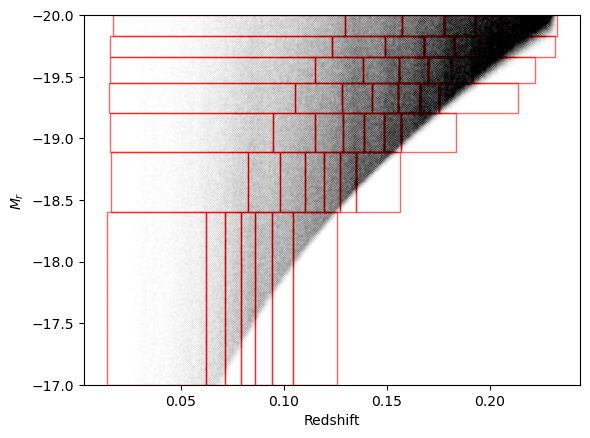

In [101]:
rshift = get_property('z', 'VF', 'all', 'BGS Bright')
mr = get_property('mr', 'VF', 'all', 'BGS Bright')
void_property = get_property('mr', 'VF', 'void', 'BGS Bright')
wall_property = get_property('mr', 'VF', 'wall', 'BGS Bright')
void_redshift = get_property('z', 'VF', 'void', 'BGS Bright')
wall_redshift = get_property('z', 'VF', 'wall', 'BGS Bright')
galaxy_redshift = get_property('z', 'VF', 'all', 'BGS Bright')
void_mr = get_property('mr', 'VF', 'void', 'BGS Bright')
wall_mr = get_property('mr', 'VF', 'wall', 'BGS Bright')
galaxy_mr = get_property('mr', 'VF', 'all', 'BGS Bright')



counts_wall = []
counts_void = []
# Define magnitude bins (M_r)
mr_mask = (void_mr >= -20) & (void_mr <= -17)
mr_bins = np.quantile(void_mr[mr_mask],
                      np.linspace(0, 1, 8))

for mrmin, mrmax in zip(mr_bins[:-1], mr_bins[1:]):
    # Pre-select redshift range for quantiles
    pre_bin = get_mr_z_bin(galaxy_redshift, 0, np.inf, galaxy_mr, mrmin, mrmax, galaxy_redshift, 'redshift')

    z_bins = np.quantile(pre_bin, np.linspace(0, 1, 8))

    for zmin, zmax in zip(z_bins[:-1], z_bins[1:]):
        void_bin = get_mr_z_bin(void_redshift, zmin, zmax, void_mr, mrmin, mrmax, void_property, 'mr')
        wall_bin = get_mr_z_bin(wall_redshift, zmin, zmax, wall_mr, mrmin, mrmax, wall_property, 'mr')


        rect = Rectangle(
            (zmin, mrmin),               # lower-left corner
            zmax - zmin,               
            mrmax - mrmin,               
            linewidth=1,
            edgecolor='red',
            facecolor='none',
            alpha=0.6
        )

        plt.gca().add_patch(rect)

        if len(void_bin) > 0 and len(wall_bin) > 0:
            # Downsample to equal sizes
            min_len = min(len(void_bin), len(wall_bin))
            np.random.seed(0)
            counts_wall.append(len(wall_bin))
            counts_void.append(len(void_bin))
            void_bin = np.random.choice(void_bin, min_len, replace=False)
            wall_bin = np.random.choice(wall_bin, min_len, replace=False)
            counts.append(2*min_len)

plt.scatter(rshift, mr, s=.0001, color='black', alpha=.2)
plt.xlabel('Redshift')
plt.ylabel(r'$M_r$')
plt.ylim(-20,-17)
plt.gca().invert_yaxis()

print("Estimated Counts ="+str(np.mean(counts)))